In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
import io

warnings.filterwarnings('ignore')

class LMS:
    """Least Mean Squares (LMS) Algorithm Implementation"""
    def __init__(self, learning_rate=0.01, n_features=None):
        self.learning_rate = learning_rate
        self.weights = None
        self.training_errors = [] 

    def fit(self, X, y, epochs=100):
        X_b = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        n_samples, n_features_with_bias = X_b.shape

        if self.weights is None:
            self.weights = np.random.normal(0, 0.1, n_features_with_bias)
        
        self.training_errors = []
        for epoch in range(epochs):
            total_squared_error_epoch = 0
            for i in range(n_samples):
                x_i_b = X_b[i]
                prediction = np.dot(x_i_b, self.weights)
                error = y[i] - prediction
                total_squared_error_epoch += error ** 2
                self.weights += self.learning_rate * error * x_i_b
            
            mse_epoch = total_squared_error_epoch / n_samples
            self.training_errors.append(mse_epoch)
        return self

    def predict(self, X):
        X_b = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        if self.weights is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        return np.dot(X_b, self.weights)

    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)


class KLMS:
    # Kernel Least Mean Squares (KLMS) Algorithm Implementation
    def __init__(self, learning_rate=0.01, kernel='rbf', gamma=1.0, max_dictionary_size=100):
        self.learning_rate = learning_rate
        self.kernel = kernel
        self.gamma = gamma
        self.max_dictionary_size = max_dictionary_size
        self.dictionary = []
        self.coefficients = []
        self.training_errors = []

    def kernel_function(self, x1, x2):
        x1_flat = np.asarray(x1).flatten()
        x2_flat = np.asarray(x2).flatten()
        if self.kernel == 'rbf':
            return np.exp(-self.gamma * np.sum((x1_flat - x2_flat) ** 2))
        elif self.kernel == 'linear':
            return np.dot(x1_flat, x2_flat)
        elif self.kernel == 'polynomial':
            return (np.dot(x1_flat, x2_flat) + 1) ** 2
        else:
            raise ValueError(f"Unsupported kernel type: {self.kernel}")

    def predict_single(self, x_new):
        if not self.dictionary:
            return 0.0
        prediction = 0.0
        for i, dict_elem in enumerate(self.dictionary):
            prediction += self.coefficients[i] * self.kernel_function(x_new, dict_elem)
        return prediction

    def fit(self, X, y, epochs=100):
        n_samples = X.shape[0]
        self.training_errors = []

        for epoch in range(epochs):
            total_squared_error_epoch = 0
            for i in range(n_samples):
                x_current = X[i]
                y_current_true = y[i]
                y_current_pred = self.predict_single(x_current)
                error = y_current_true - y_current_pred
                total_squared_error_epoch += error ** 2
                
                if len(self.dictionary) < self.max_dictionary_size:
                    self.dictionary.append(x_current.copy())
                    self.coefficients.append(self.learning_rate * error)
                else:
                    distances_sq = [np.sum((x_current - dict_elem) ** 2) for dict_elem in self.dictionary]
                    closest_idx = np.argmin(distances_sq)
                    self.coefficients[closest_idx] += self.learning_rate * error 
            
            mse_epoch = total_squared_error_epoch / n_samples
            self.training_errors.append(mse_epoch)
        return self

    def predict(self, X_test):
        predictions = np.array([self.predict_single(x) for x in X_test])
        return predictions

    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

In [14]:
def plot_results(lms_model, klms_model, X_test, y_test, train_errors_lms, train_errors_klms, filename="lms_vs_klms_plot.png"):
    # Plot comparison results
    fig, axes = plt.subplots(2, 2, figsize=(18, 14)) 

    # Plot 1: Training Error Curves
    axes[0, 0].plot(train_errors_lms, label='LMS Training Error', color='blue', linewidth=2)
    axes[0, 0].plot(train_errors_klms, label='KLMS Training Error', color='red', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Mean Squared Error')
    axes[0, 0].set_title('Training Error Convergence')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')

    # Make predictions for plotting
    y_pred_lms = lms_model.predict(X_test)
    y_pred_klms = klms_model.predict(X_test)

    mse_lms_test = lms_model.mse(y_test, y_pred_lms)
    mse_klms_test = klms_model.mse(y_test, y_pred_klms)

    # Plot 2: LMS Predictions vs Actual
    axes[0, 1].scatter(y_test, y_pred_lms, alpha=0.6, color='blue', label=f'Test MSE: {mse_lms_test:.4f}')
    min_val_lms = min(y_test.min(), y_pred_lms.min()) if len(y_pred_lms) > 0 else y_test.min()
    max_val_lms = max(y_test.max(), y_pred_lms.max()) if len(y_pred_lms) > 0 else y_test.max()
    axes[0, 1].plot([min_val_lms, max_val_lms], [min_val_lms, max_val_lms], 'k--', lw=2)
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('LMS Predicted Values')
    axes[0, 1].set_title(f'LMS: Predicted vs Actual')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: KLMS Predictions vs Actual
    axes[1, 0].scatter(y_test, y_pred_klms, alpha=0.6, color='red', label=f'Test MSE: {mse_klms_test:.4f}')
    min_val_klms = min(y_test.min(), y_pred_klms.min()) if len(y_pred_klms) > 0 else y_test.min()
    max_val_klms = max(y_test.max(), y_pred_klms.max()) if len(y_pred_klms) > 0 else y_test.max()
    axes[1, 0].plot([min_val_klms, max_val_klms], [min_val_klms, max_val_klms], 'k--', lw=2)
    axes[1, 0].set_xlabel('Actual Values')
    axes[1, 0].set_ylabel('KLMS Predicted Values')
    axes[1, 0].set_title(f'KLMS: Predicted vs Actual')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Error Distribution Comparison
    errors_lms = y_test - y_pred_lms
    errors_klms = y_test - y_pred_klms
    
    if len(errors_lms) > 0 and len(errors_klms) > 0:
        max_abs_error = max(np.abs(errors_lms).max(), np.abs(errors_klms).max())
        bins = np.linspace(-max_abs_error, max_abs_error, 30)
    elif len(errors_lms) > 0:
        max_abs_error = np.abs(errors_lms).max()
        bins = np.linspace(-max_abs_error, max_abs_error, 30)
    elif len(errors_klms) > 0:
        max_abs_error = np.abs(errors_klms).max()
        bins = np.linspace(-max_abs_error, max_abs_error, 30)
    else:
        bins = 30 

    axes[1, 1].hist(errors_lms, bins=bins, alpha=0.7, label='LMS Errors', color='blue', density=True)
    axes[1, 1].hist(errors_klms, bins=bins, alpha=0.7, label='KLMS Errors', color='red', density=True)
    axes[1, 1].set_xlabel('Prediction Error (y_true - y_pred)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Error Distribution Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.25)
    plt.savefig(filename) 
    print(f"Plot saved to {filename}")
    plt.show() 

In [15]:
df = pd.read_csv("/kaggle/input/klms-dataset/nonlinear_dataset.csv")
data_file_object = io.StringIO("/kaggle/input/klms-dataset/nonlinear_dataset.csv")
df_loaded = pd.read_csv("/kaggle/input/klms-dataset/nonlinear_dataset.csv")

# Extract X and y
X_loaded = df_loaded[['feature_1', 'feature_2', 'feature_3']].values
y_loaded = df_loaded['target'].values

print(f"Dataset shape from string: X={X_loaded.shape}, y={y_loaded.shape}")
print(df_loaded.head())

Dataset shape from string: X=(1000, 3), y=(1000,)
   feature_1  feature_2  feature_3    target
0  -0.501840   1.802857   0.927976  1.578134
1   0.394634  -1.375925  -1.376022  1.423405
2  -1.767666   1.464705   0.404460  0.302936
3   0.832290  -1.917662   1.879639  1.658821
4   1.329771  -1.150644  -1.272700  1.588952


LMS vs KLMS Algorithm Comparison
Target statistics: Mean=1.183, Std=1.164

2. Splitting data into training and testing sets...
Training set size: 800
Test set size: 200

3. Standardizing features...

4. Training LMS model (epochs=100, lr=0.01)...

5. Training KLMS model (epochs=100, lr=0.1, gamma=0.5, dict_size=50)...

6. Evaluating models on the test set...

Final Test Results:
LMS Test MSE: 0.8567
KLMS Test MSE: 0.0569
KLMS Final Dictionary Size: 50

7. Plotting comparison results...
Plot saved to klms_lms_on_kaggle.png


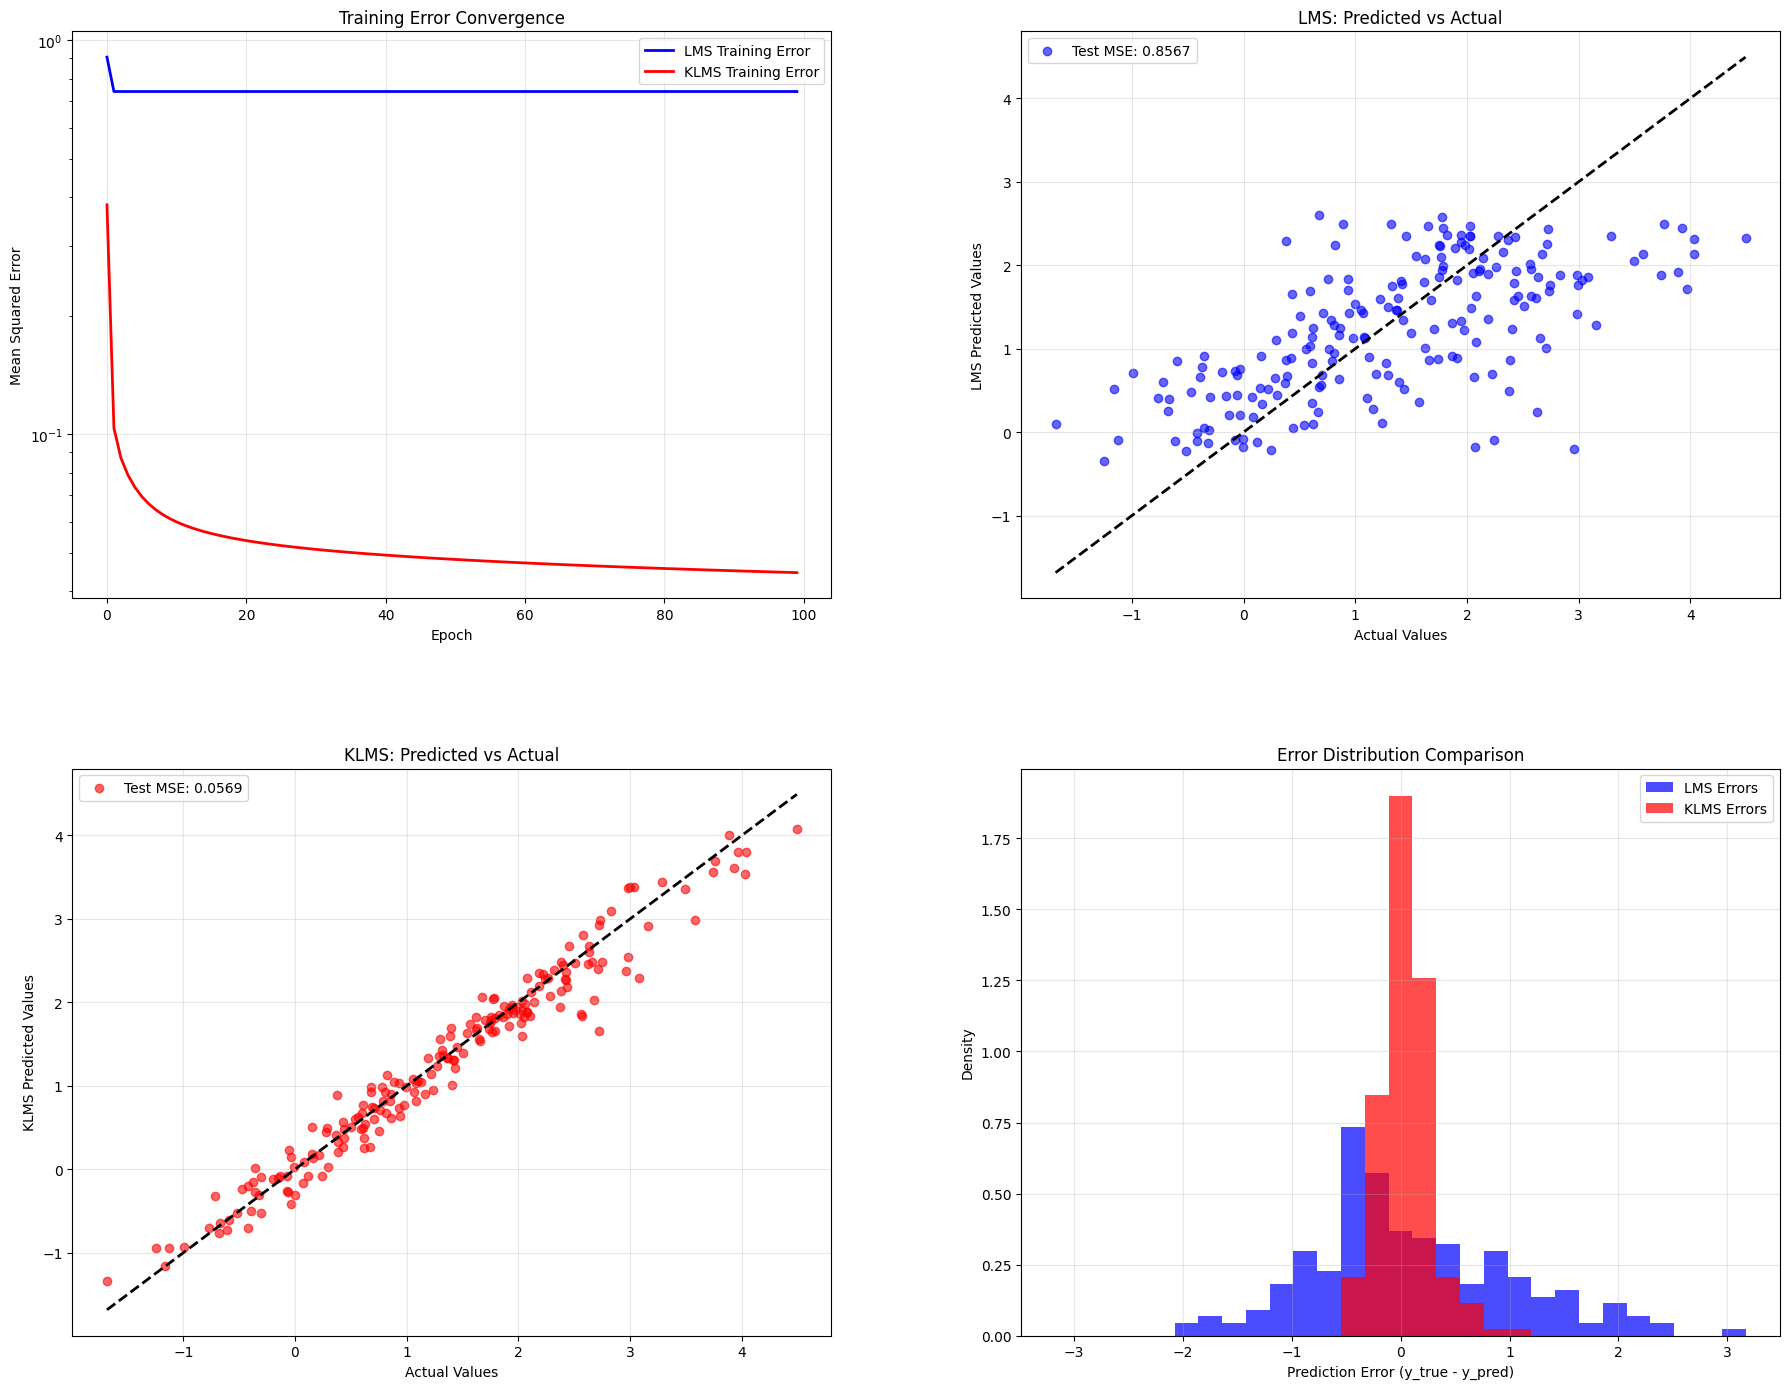


8. Loaded Dataset Sample (first 10 rows):
   feature_1  feature_2  feature_3    target
0  -0.501840   1.802857   0.927976  1.578134
1   0.394634  -1.375925  -1.376022  1.423405
2  -1.767666   1.464705   0.404460  0.302936
3   0.832290  -1.917662   1.879639  1.658821
4   1.329771  -1.150644  -1.272700  1.588952
5  -1.266382  -0.783031   0.099026  0.671257
6  -0.272220  -0.835083   0.447412  1.012652
7  -1.442025  -0.831421  -0.534553  0.588425
8  -0.175720   1.140704  -1.201305  0.599170
9   0.056938   0.369658  -1.814198 -0.068596

Script finished.


In [16]:
print("LMS vs KLMS Algorithm Comparison")

print(f"Target statistics: Mean={np.mean(y_loaded):.3f}, Std={np.std(y_loaded):.3f}")

# Step 2: Split data into train and test sets
print("\n2. Splitting data into training and testing sets...")
if len(X_loaded) < 10:
    print("Dataset too small. Using all data for training and testing.")
    X_train, X_test = X_loaded, X_loaded
    y_train, y_test = y_loaded, y_loaded
else:
    train_size = int(0.8 * len(X_loaded))
    X_train, X_test = X_loaded[:train_size], X_loaded[train_size:]
    y_train, y_test = y_loaded[:train_size], y_loaded[train_size:]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Step 3: Standardize features
print("\n3. Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lms_epochs = 100 
lms_lr = 0.01 

klms_epochs = 100 
klms_lr = 0.1
klms_gamma = 0.5
klms_dict_size = 50

# Step 4: Train LMS model
print(f"\n4. Training LMS model (epochs={lms_epochs}, lr={lms_lr})...")
lms_model = LMS(learning_rate=lms_lr)
lms_model.fit(X_train_scaled, y_train, epochs=lms_epochs)

# Step 5: Train KLMS model
print(f"\n5. Training KLMS model (epochs={klms_epochs}, lr={klms_lr}, gamma={klms_gamma}, dict_size={klms_dict_size})...")
klms_model = KLMS(learning_rate=klms_lr, kernel='rbf', 
                  gamma=klms_gamma, max_dictionary_size=klms_dict_size)
klms_model.fit(X_train_scaled, y_train, epochs=klms_epochs)

# Step 6: Evaluate models on test set
print("\n6. Evaluating models on the test set...")
y_pred_lms_test = lms_model.predict(X_test_scaled)
mse_lms_test = lms_model.mse(y_test, y_pred_lms_test)

y_pred_klms_test = klms_model.predict(X_test_scaled)
mse_klms_test = klms_model.mse(y_test, y_pred_klms_test)

print(f"\nFinal Test Results:")
print(f"LMS Test MSE: {mse_lms_test:.4f}")
print(f"KLMS Test MSE: {mse_klms_test:.4f}")
print(f"KLMS Final Dictionary Size: {len(klms_model.dictionary)}")

# Step 7: Plot results
print("\n7. Plotting comparison results...")
plot_results(lms_model, klms_model, X_test_scaled, y_test, 
             lms_model.training_errors, klms_model.training_errors,
             filename="klms_lms_on_kaggle.png")

# Step 8: Display dataset sample
print("\n8. Loaded Dataset Sample (first 10 rows):")
print(df_loaded.head(10))

print("\nScript finished.")